# Resume Parsing

I assume that the system is emphasize on IT resume

In [1]:
import pandas as pd
import numpy as np

# the dataset to test the spacy pipeline 
df_resume = pd.read_csv("data/resume.csv")

In [2]:
df_resume.shape

(2484, 4)

In [3]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [4]:
# capture only on IT resume
df_resume = df_resume[df_resume.Category=='INFORMATION-TECHNOLOGY']
df_resume

,ID,Resume_str,Resume_html,Category
217,36856210,INFORMATION TECHNOLOGY Summar...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
218,21780877,INFORMATION TECHNOLOGY SPECIALIST\tGS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
219,33241454,INFORMATION TECHNOLOGY SUPERVISOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
220,25990239,INFORMATION TECHNOLOGY INSTRUCTOR ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
221,16899268,INFORMATION TECHNOLOGY MANAGER/ANALYS...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
...,...,...,...,...
332,27485716,CORPORATE PROJECT MANAGER Caree...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
333,26480367,IT TECHNOLOGY SPECIALIST Profes...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
334,81761658,IT MANAGER Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
335,79541391,SUBJECT MATTER EXPERT (INFORMATION TE...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY


## Task 1: Implementation Foundation

In [5]:
import spacy

# load spacy  
nlp = spacy.load('en_core_web_sm', exclude = ['ner'])
skill_path = 'data/skills.jsonl' # skills.json1 from Chaky provide

In [6]:
# add skill to spacy pipeline
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler']

In [7]:
# assign the experience label to pipeline
patterns = [
    {"label": 'EXPERIENCE', "pattern": "assistant professor"},
    {"label": 'EXPERIENCE', "pattern": "postdoctoral researcher"},
    {"label": 'EXPERIENCE', "pattern": "visiting professor"},
    {"label": 'EXPERIENCE', "pattern": "programmer"},
    {"label": 'EXPERIENCE', "pattern": "research assistant"},
    {"label": 'EXPERIENCE', "pattern": "data scientist"},
    {"label": 'EXPERIENCE', "pattern": "data engineer"},
    {"label": 'EXPERIENCE', "pattern": "data analyst"},
    {"label": 'EXPERIENCE', "pattern": "machine learning engineer"},
    {"label": 'EXPERIENCE', "pattern": "project manager"},
]

ruler.add_patterns(patterns)

In [8]:

# assign the contact label which include email and phone number to pipeline
patterns = [
    # label for email
    {"label": "CONTACT", "pattern": [{"TEXT": {"REGEX": "[a-zA-Z0-9._-]+@[a-zA-Z]+\\.[a-zA-Z]{2,}"}}]}, #noppawee_tee@gmail.com
    # label for phone number
    {"label": "CONTACT",  "pattern": [{"TEXT": {"REGEX":"\d{10}"}}]},
    {"label": "CONTACT",  "pattern": [{"TEXT": {"REGEX":"\d{9}"}}]},
    {"label": "CONTACT",  "pattern": [{"TEXT": {"REGEX":"\d{3}[-\s]??\d{3}[-\s]??\d{4}"}}]},
    {"label": "CONTACT",  "pattern": [{"TEXT": {"REGEX":"\d{2}[-\s]??\d{3}[-\s]??\d{4}"}}]},
   
]

ruler.add_patterns(patterns)

In [9]:
#assign the certifications to pipeline

patterns = [
    {"label": 'CERTIFICATE', "pattern": "doctor"},
    {"label": 'CERTIFICATE', "pattern": "master"},
    {"label": 'CERTIFICATE', "pattern": "bachelor"},
]

ruler.add_patterns(patterns)

In [10]:
# Save the updated pipeline to a directory
output_dir = "./spacy"
nlp.to_disk(output_dir)

In [11]:
# sample text to test the spacy pipeline
text = "I am programmer, (+66)825217644, 082-521-7644, +66825217644, 0825217644, bachelor's"

In [12]:
doc = nlp(text)

In [13]:
# print text along with their labels
for ent in doc.ents:
    print(ent.text, ent.label_)

programmer EXPERIENCE
+66)825217644 CONTACT
+66825217644 CONTACT
0825217644 CONTACT
bachelor CERTIFICATE


In [14]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [15]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'           Christopher    Townes         Summary     Knowledgeable Information Technology Specialist capable of setting up and optimizing workstations, training users and assisting with process improvement implementation in diverse areas. Familiar with Cicso business practices and IT standards. Exce'

In [16]:
preprocessing(random_resume[:300])

'christopher townes summary knowledgeable information technology specialist capable set optimize workstation train user assist process improvement implementation diverse area familiar cicso business practice it standard exce'

In [17]:
# clean text in each row of DataFrame
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

## Task 2 Demo for web application

In [18]:
# load saved spacy
nlp_loaded = spacy.load("./spacy")

In [19]:
# function to separate the type of label
def get_info(text):
    
    doc = nlp_loaded(text)
    
    skills = []
    experiences = []
    certificates = []
    contacts = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
        elif ent.label_ == 'EXPERIENCE':
            experiences.append(ent.text)
        elif ent.label_ == 'CERTIFICATE':
            certificates.append(ent.text)    
        elif ent.label_ == 'CONTACT':
            contacts.append(ent.text)    
    
    skills = list(set(skills))
    experiences = list(set(experiences))
    certificates = list(set(certificates))
    contacts = list(set(contacts))

    skills = ", ".join(skills)
    experiences = ", ".join(experiences)
    certificates = ", ".join(certificates)
    contacts = ", ".join(contacts)

    return [skills], [experiences], [certificates], [contacts]

In [20]:
# load the pdf file
from PyPDF2 import PdfReader
text_pdf = ""
reader = PdfReader("Noppawee_CV.pdf")
page = reader.pages[0]
for page in reader.pages:
    text_pdf += page.extract_text()

In [21]:
text_pdf = preprocessing(text_pdf)

In [22]:
skill, exp, certi, con = get_info(text_pdf)

In [23]:
skill

['data science, engineering, robot, algorithm, raspberry pi, ai, linux, python, machine learning, mysql, image processing, programming language, segment']

In [24]:
exp

['programmer, research assistant']

In [25]:
certi

['bachelor']

In [33]:
con

['earthhnopp@gmail.com, +66)825217644']

In [26]:
# Creating an empty DataFrame
result_df = pd.DataFrame()

In [27]:
# assign the value to the empty DataFrame
result_df['skills'] = skill
result_df['experiences'] = exp
result_df['certificates'] = certi
result_df['contacts'] = con

In [29]:
result_df

,skills,experiences,certificates,contacts
0,"data science, engineering, robot, algorithm, r...","programmer, research assistant",bachelor,"earthhnopp@gmail.com, +66)825217644"


In [30]:
# save the dataframe on excel file
# pip install openpyxl
result_df.to_excel("output.xlsx", index=False)  

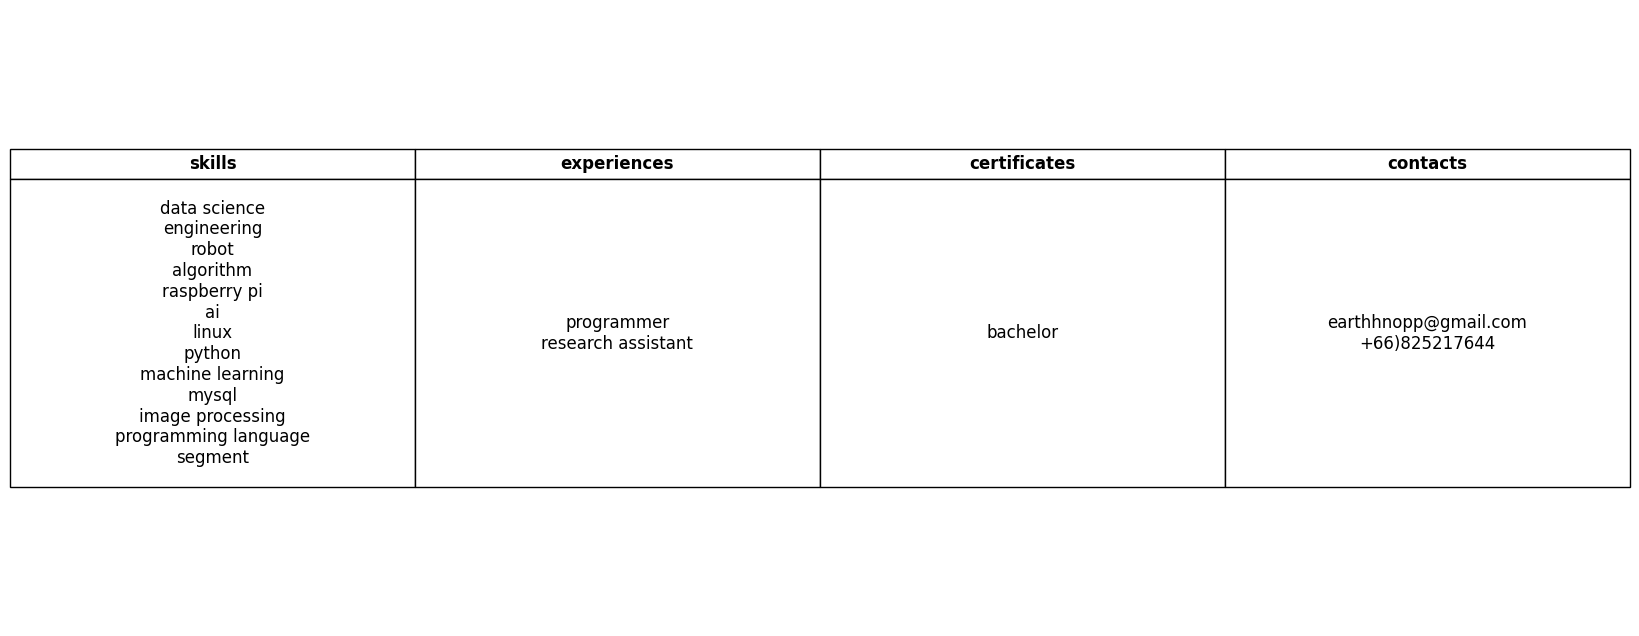

In [31]:
import matplotlib.pyplot as plt

# replace commas with new line (\n)
result_df['skills'] = result_df['skills'].str.replace(', ', '\n')
result_df['experiences'] = result_df['experiences'].str.replace(', ', '\n')
result_df['certificates'] = result_df['certificates'].str.replace(', ', '\n')
result_df['contacts'] = result_df['contacts'].str.replace(', ', '\n')

# calculate the required width for each column based on the maximum text length
column_widths = [max(result_df[col].apply(lambda x: len(str(x)))) for col in result_df.columns]

# plot DataFrame with larger font size and multiline text
plt.figure(figsize=(sum(column_widths) * 0.1, (result_df.shape[0]+1) * 4))
# plot table
table = plt.table(cellText=result_df.values, colLabels=result_df.columns, loc='center', cellLoc='center')

# adjust cell sizes to fit content
for (i, j), cell in table.get_celld().items():
    if (i == 0):  
        cell.set_text_props(fontsize=12, fontweight='bold') 
        cell.set_height(0.05)  
    else: 
        cell.set_height(0.5) 

# adjust font size
table.auto_set_font_size(False)
table.set_fontsize(12)  

plt.axis('off')  # turn off axis
plt.savefig('output.png')  # save as PNG image
plt.show()

In [32]:
# display label the tokens by spacy 
from spacy import displacy
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

doc=nlp_loaded(text_pdf)

displacy.render(doc, style='ent', options=options)